In [31]:
import pandas as pd
import json
import geopandas as gpd
import os
%matplotlib inline
import geopandas as gp
import pandas as pd
import math
from shapely.geometry import MultiLineString
from shapely.geometry import MultiPoint
import numpy as np
from shapely import geometry
from shapely.geometry import Point, Polygon, box,LineString
from shapely.ops import nearest_points
from geopandas import datasets, GeoDataFrame, read_file
from geopandas.tools import overlay
from matplotlib import pyplot
import matplotlib.pyplot as plt
from shapely.geometry.polygon import LinearRing, Polygon
from numpy import cos,sin,arccos
import numpy as np
from pylab import *
from shapely.ops import cascaded_union
from shapely.geometry import Point, LineString, mapping
import scipy.interpolate
import time
import cudf
import cugraph
import folium

In [7]:
traffic_flow = gpd.read_file("traffic_flow_shp/traffic_flow_26082020/traffic_flow_26082020_2100_2200.shp")
traffic_flow.head()

,TMC_PC,TMC_DE,TMC_QD,TMC_LE,FC,CF_SP,CF_SU,CF_FF,CF_JF,CF_CN,PBT,DE,geometry
0,5802,E37/Lebuhraya Hubungan Timur-Barat/Lebuhraya S...,-,0.71360,2,70.00,70.00,70.0,0.00000,0.70,2020-08-26T21:09:35Z,Lebuhraya Cheras-Kajang/Lebuhraya CKE/Cheras-K...,"LINESTRING (101.74195 3.08229, 101.74197 3.082..."
1,5803,Jalan Cheras Hartamas,-,0.11864,2,70.00,70.00,70.0,0.00000,0.70,2020-08-26T21:09:35Z,Lebuhraya Cheras-Kajang/Lebuhraya CKE/Cheras-K...,"LINESTRING (101.74658 3.07899, 101.74688 3.078..."
2,5804,Jalan Medan Masria,-,1.14547,2,85.00,85.00,90.0,0.81481,0.70,2020-08-26T21:09:35Z,Lebuhraya Cheras-Kajang/Lebuhraya CKE/Cheras-K...,"LINESTRING (101.74763 3.07880, 101.74779 3.078..."
3,5803,Jalan Cheras Hartamas,+,0.71240,2,71.00,71.00,84.2,2.29928,0.70,2020-08-26T21:09:35Z,Lebuhraya Cheras-Kajang/Lebuhraya CKE/Cheras-K...,"LINESTRING (101.74829 3.07853, 101.74802 3.078..."
4,5802,E37/Lebuhraya Hubungan Timur-Barat/Lebuhraya S...,+,0.82177,2,59.37,59.37,67.6,1.78578,0.71,2020-08-26T21:09:35Z,Lebuhraya Cheras-Kajang/Lebuhraya CKE/Cheras-K...,"LINESTRING (101.74715 3.07869, 101.74685 3.078..."


In [8]:
traffic_flow.dtypes

TMC_PC         int64
TMC_DE        object
TMC_QD        object
TMC_LE       float64
FC             int64
CF_SP        float64
CF_SU        float64
CF_FF        float64
CF_JF        float64
CF_CN        float64
PBT           object
DE            object
geometry    geometry
dtype: object

In [9]:
traffic_flow['endpoints'] = traffic_flow['geometry'].apply(lambda x: x.boundary)



In [10]:
def return_start_point(x):
    #print(x)
    try:
        return x.boundary[0]
    except:
        return None

def return_end_point(x):
    try:
        return x.boundary[1]
    except:
        return None
    

traffic_flow['start_point'] = traffic_flow['geometry'].apply(lambda x: return_start_point(x))
traffic_flow['end_point'] = traffic_flow['geometry'].apply(lambda x: return_end_point(x))

In [11]:
traffic_flow.head()

,TMC_PC,TMC_DE,TMC_QD,TMC_LE,FC,CF_SP,CF_SU,CF_FF,CF_JF,CF_CN,PBT,DE,geometry,endpoints,start_point,end_point
0,5802,E37/Lebuhraya Hubungan Timur-Barat/Lebuhraya S...,-,0.71360,2,70.00,70.00,70.0,0.00000,0.70,2020-08-26T21:09:35Z,Lebuhraya Cheras-Kajang/Lebuhraya CKE/Cheras-K...,"LINESTRING (101.74195 3.08229, 101.74197 3.082...","MULTIPOINT (101.74195 3.08229, 101.74658 3.07899)",POINT (101.74195 3.08229),POINT (101.74658 3.07899)
1,5803,Jalan Cheras Hartamas,-,0.11864,2,70.00,70.00,70.0,0.00000,0.70,2020-08-26T21:09:35Z,Lebuhraya Cheras-Kajang/Lebuhraya CKE/Cheras-K...,"LINESTRING (101.74658 3.07899, 101.74688 3.078...","MULTIPOINT (101.74658 3.07899, 101.74763 3.07880)",POINT (101.74658 3.07899),POINT (101.74763 3.07880)
2,5804,Jalan Medan Masria,-,1.14547,2,85.00,85.00,90.0,0.81481,0.70,2020-08-26T21:09:35Z,Lebuhraya Cheras-Kajang/Lebuhraya CKE/Cheras-K...,"LINESTRING (101.74763 3.07880, 101.74779 3.078...","MULTIPOINT (101.74763 3.07880, 101.74830 3.07868)",POINT (101.74763 3.07880),POINT (101.74830 3.07868)
3,5803,Jalan Cheras Hartamas,+,0.71240,2,71.00,71.00,84.2,2.29928,0.70,2020-08-26T21:09:35Z,Lebuhraya Cheras-Kajang/Lebuhraya CKE/Cheras-K...,"LINESTRING (101.74829 3.07853, 101.74802 3.078...","MULTIPOINT (101.74829 3.07853, 101.74715 3.07869)",POINT (101.74829 3.07853),POINT (101.74715 3.07869)
4,5802,E37/Lebuhraya Hubungan Timur-Barat/Lebuhraya S...,+,0.82177,2,59.37,59.37,67.6,1.78578,0.71,2020-08-26T21:09:35Z,Lebuhraya Cheras-Kajang/Lebuhraya CKE/Cheras-K...,"LINESTRING (101.74715 3.07869, 101.74685 3.078...","MULTIPOINT (101.74715 3.07869, 101.74182 3.08248)",POINT (101.74715 3.07869),POINT (101.74182 3.08248)


In [12]:
traffic_flow = traffic_flow.dropna()

In [13]:
#traffic_flow['road_condition'] = 10 - traffic_flow['CF_JF']
traffic_flow['road_condition'] = traffic_flow['CF_JF']

In [14]:
print(len(traffic_flow))

120828


<AxesSubplot:>

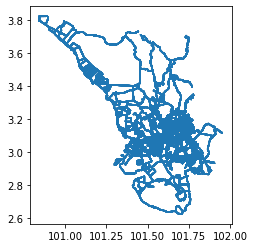

In [15]:
traffic_flow.plot()

In [16]:
print(cugraph.__version__)

0+untagged.1.g892a8e1


In [17]:
traffic_flow.head()

,TMC_PC,TMC_DE,TMC_QD,TMC_LE,FC,CF_SP,CF_SU,CF_FF,CF_JF,CF_CN,PBT,DE,geometry,endpoints,start_point,end_point,road_condition
0,5802,E37/Lebuhraya Hubungan Timur-Barat/Lebuhraya S...,-,0.71360,2,70.00,70.00,70.0,0.00000,0.70,2020-08-26T21:09:35Z,Lebuhraya Cheras-Kajang/Lebuhraya CKE/Cheras-K...,"LINESTRING (101.74195 3.08229, 101.74197 3.082...","MULTIPOINT (101.74195 3.08229, 101.74658 3.07899)",POINT (101.74195 3.08229),POINT (101.74658 3.07899),0.00000
1,5803,Jalan Cheras Hartamas,-,0.11864,2,70.00,70.00,70.0,0.00000,0.70,2020-08-26T21:09:35Z,Lebuhraya Cheras-Kajang/Lebuhraya CKE/Cheras-K...,"LINESTRING (101.74658 3.07899, 101.74688 3.078...","MULTIPOINT (101.74658 3.07899, 101.74763 3.07880)",POINT (101.74658 3.07899),POINT (101.74763 3.07880),0.00000
2,5804,Jalan Medan Masria,-,1.14547,2,85.00,85.00,90.0,0.81481,0.70,2020-08-26T21:09:35Z,Lebuhraya Cheras-Kajang/Lebuhraya CKE/Cheras-K...,"LINESTRING (101.74763 3.07880, 101.74779 3.078...","MULTIPOINT (101.74763 3.07880, 101.74830 3.07868)",POINT (101.74763 3.07880),POINT (101.74830 3.07868),0.81481
3,5803,Jalan Cheras Hartamas,+,0.71240,2,71.00,71.00,84.2,2.29928,0.70,2020-08-26T21:09:35Z,Lebuhraya Cheras-Kajang/Lebuhraya CKE/Cheras-K...,"LINESTRING (101.74829 3.07853, 101.74802 3.078...","MULTIPOINT (101.74829 3.07853, 101.74715 3.07869)",POINT (101.74829 3.07853),POINT (101.74715 3.07869),2.29928
4,5802,E37/Lebuhraya Hubungan Timur-Barat/Lebuhraya S...,+,0.82177,2,59.37,59.37,67.6,1.78578,0.71,2020-08-26T21:09:35Z,Lebuhraya Cheras-Kajang/Lebuhraya CKE/Cheras-K...,"LINESTRING (101.74715 3.07869, 101.74685 3.078...","MULTIPOINT (101.74715 3.07869, 101.74182 3.08248)",POINT (101.74715 3.07869),POINT (101.74182 3.08248),1.78578


In [79]:
monash = Point(3.064932, 101.601016)
mimos = Point(3.046843, 101.696183)
home = Point(3.027020, 101.570559)

sunway = Point(3.071410, 101.607970)
klsentral = Point(3.133816, 101.684744)
klcc = Point(3.15784,101.712135)

start = monash
end = klcc

stops = [mimos, home, sunway, klsentral]
markers = [monash, mimos, home, sunway, klsentral, klcc]

In [50]:
def get_graph_node(x):
    return [o.wkt for o in nearest_points(x, MultiPoint(graph_nodes))][1]

def get_node(x):
    x = x.replace('(','')
    x = x.replace(')','')
    x = x.split(' ')
    
    return float(x[1]), float(x[2])

#monash = (3.064932, 101.601016)
print(get_graph_node(Point(monash)))
print(get_graph_node(Point(monash)).split(' '))
print(node_dict_gps_to_node.get(get_node(get_graph_node(Point(monash)))))

POINT (3.06528 101.59911)
['POINT', '(3.06528', '101.59911)']
115094


## Edge DataFrame

In [18]:
edge_arr_distance = []
edge_arr_roadCondition = []
node_dict_gps_to_node = {}
node_dict_node_to_gps = {}
node_counter = 0

for row in traffic_flow.iterrows():
    #print(list(zip(row[1]['start_point'].coords.xy)))
    if row[1]['geometry'].geom_type == 'LineString':
        for seg_start, seg_end in zip(list(row[1]['geometry'].coords),list(row[1]['geometry'].coords)[1:]):
            seg_start_gps = (seg_start[1], seg_start[0])
            seg_end_gps = (seg_end[1], seg_end[0])
            
            if node_dict_gps_to_node.get(seg_start_gps) is None:
                node_dict_gps_to_node[seg_start_gps] = node_counter
                node_dict_node_to_gps[node_counter] = seg_start_gps
                node_counter += 1
                
            if node_dict_gps_to_node.get(seg_end_gps) is None:
                node_dict_gps_to_node[seg_end_gps] = node_counter
                node_dict_node_to_gps[node_counter] = seg_start_gps
                node_counter += 1
            
            edge_arr_distance.append([node_dict_gps_to_node[seg_start_gps], node_dict_gps_to_node[seg_end_gps], float(row[1]['TMC_LE'])])
            edge_arr_roadCondition.append([node_dict_gps_to_node[seg_start_gps], node_dict_gps_to_node[seg_end_gps], float(row[1]['road_condition'])])
            #print(seg_start_gps)
            #kl_selangor_graph_distance.add_nodes_from([seg_start_gps, seg_end_gps])
            #kl_selangor_graph_distance.add_nodes_from(seg_start_gps)
            #kl_selangor_graph_distance.add_nodes_from(seg_end_gps)
            #kl_selangor_graph_distance.add_edge(seg_start_gps, seg_end_gps, weight=float(row[1]['TMC_LE']))
            #kl_selangor_graph_roadCondition.add_nodes_from([seg_start_gps, seg_end_gps])
            #kl_selangor_graph_roadCondition.add_edge(seg_start_gps, seg_end_gps, weight=float(row[1]['road_condition']))
            #graph_nodes.append(Point(seg_start_gps))
            #graph_nodes.append(Point(seg_end_gps))
    elif row[1]['geometry'].geom_type == 'MultiLineString':
        for line_part in row[1]['geometry']:
            for seg_start, seg_end in zip(list(line_part.coords),list(line_part.coords)[1:]):
                seg_start_gps = (seg_start[1], seg_start[0])
                seg_end_gps = (seg_end[1], seg_end[0])
                
                if node_dict_gps_to_node.get(seg_start_gps) is None:
                    #print(seg_start_gps)
                    node_dict_gps_to_node[seg_start_gps] = node_counter
                    node_dict_node_to_gps[node_counter] = seg_start_gps
                    node_counter += 1

                if node_dict_gps_to_node.get(seg_end_gps) is None:
                    #print(seg_end_gps)
                    node_dict_gps_to_node[seg_end_gps] = node_counter
                    node_dict_node_to_gps[node_counter] = seg_start_gps
                    node_counter += 1

                edge_arr_distance.append([node_dict_gps_to_node[seg_start_gps], node_dict_gps_to_node[seg_end_gps], float(row[1]['TMC_LE'])])
                edge_arr_roadCondition.append([node_dict_gps_to_node[seg_start_gps], node_dict_gps_to_node[seg_end_gps], float(row[1]['road_condition'])])
                #print(seg_start_gps)
                #kl_selangor_graph_distance.add_nodes_from([seg_start_gps, seg_end_gps])
                #kl_selangor_graph_distance.add_edge(seg_start_gps, seg_end_gps, weight=float(row[1]['TMC_LE']))
                #kl_selangor_graph_roadCondition.add_nodes_from([seg_start_gps, seg_end_gps])
                #kl_selangor_graph_roadCondition.add_edge(seg_start_gps, seg_end_gps, weight=float(row[1]['road_condition']))
               

            
            

In [29]:
graph_nodes = []
for item in node_dict_node_to_gps.values():
    #print(item)
    graph_nodes.append(Point(item))

In [51]:
def get_graph_node(x):
    return [o.wkt for o in nearest_points(x, MultiPoint(graph_nodes))][1]

def get_node(x):
    x = x.replace('(','')
    x = x.replace(')','')
    x = x.split(' ')
    
    return float(x[1]), float(x[2])

#monash = (3.064932, 101.601016)
print(get_graph_node(Point(monash)))
print(get_graph_node(Point(monash)).split(' '))
print(node_dict_gps_to_node.get(get_node(get_graph_node(Point(monash)))))

POINT (3.06528 101.59911)
['POINT', '(3.06528', '101.59911)']
115094


In [44]:
seg_start_gps

(3.1207, 101.59724)

In [45]:
print(node_dict_gps_to_node.get(seg_start_gps))
print(node_dict_gps_to_node.get(seg_end_gps))
print(node_dict_gps_to_node.get(get_node(get_graph_node(Point(monash)))))

103029
103030
115094


In [46]:
test = pd.DataFrame(edge_arr_distance)
print(len(test))
test.head()

2447040


,0,1,2
0,0,1,0.7136
1,1,2,0.7136
2,2,3,0.7136
3,3,4,0.7136
4,4,5,0.7136


In [198]:
test = pd.DataFrame(edge_arr_roadCondition)
print(len(test))
test.head()

2447040


,0,1,2
0,0,1,0.0
1,1,2,0.0
2,2,3,0.0
3,3,4,0.0
4,4,5,0.0


### Creation of the dataframe for multiple layers

In [60]:
for stop in stops:
    print(node_dict_gps_to_node.get(get_node(get_graph_node(Point(stop)))))

26054
127180
77417
23899


In [104]:
distance_df = pd.DataFrame(edge_arr_distance)
distance_df[0] = distance_df[0].astype(str) + '_0'
distance_df[1] = distance_df[1].astype(str) + '_0'
connecting_row = []
connecting_node = node_dict_gps_to_node.get(get_node(get_graph_node(Point(start))))
connecting_row.append(str(connecting_node) + '_0')
connecting_row.append(str(connecting_node) + '_1')
connecting_row.append(0)
distance_df = distance_df.append(pd.DataFrame([connecting_row]), ignore_index=True)

stop_counter = 1
for stop in stops:
    intermediate_layer = pd.DataFrame(edge_arr_distance)
    intermediate_layer[0] = intermediate_layer[0].astype(str) + '_' + str(stop_counter)
    intermediate_layer[1] = intermediate_layer[1].astype(str) + '_' + str(stop_counter)
    distance_df = distance_df.append(intermediate_layer, ignore_index=True)
    
    ## Adding the row that contains the connecting node for the nodes to connect
    connecting_row = []
    connecting_node = node_dict_gps_to_node.get(get_node(get_graph_node(Point(stop))))
    connecting_row.append(str(connecting_node) + '_' + (str(stop_counter)))
    stop_counter += 1
    connecting_row.append(str(connecting_node) + '_' + (str(stop_counter)))
    connecting_row.append(0)
    print(connecting_row)
    distance_df = distance_df.append(pd.DataFrame([connecting_row]), ignore_index=True)
    
    
final_layer = pd.DataFrame(edge_arr_distance)
final_layer[0] = final_layer[0].astype(str) + '_' + str(stop_counter)
final_layer[1] = final_layer[1].astype(str) + '_' + str(stop_counter)
distance_df = distance_df.append(final_layer, ignore_index=True)


['26054_1', '26054_2', 0]
['127180_2', '127180_3', 0]
['77417_3', '77417_4', 0]
['23899_4', '23899_5', 0]


In [105]:
len(distance_df)

14682245

In [106]:
distance_df.tail()

,0,1,2
14682240,103025_5,103026_5,0.186
14682241,103026_5,103027_5,0.186
14682242,103027_5,103028_5,0.186
14682243,103028_5,103029_5,0.186
14682244,103029_5,103030_5,0.186


In [119]:
distance_df[distance_df[0] == '26054_1']

,0,1,2
2479453,26054_1,26055_1,1.67465
2515995,26054_1,26055_1,1.67465
2544817,26054_1,26055_1,1.67465
2548360,26054_1,26055_1,1.67465
2580183,26054_1,26055_1,1.67465
2591109,26054_1,26055_1,1.67465
2601523,26054_1,26055_1,1.67465
2620394,26054_1,26055_1,1.67465
2652706,26054_1,26055_1,1.67465
2714413,26054_1,26055_1,1.67465


In [120]:
distance_df[distance_df[1] == '26054_2']

,0,1,2
4894081,26054_1,26054_2,0.00000
4926493,26053_2,26054_2,1.67465
4963035,26053_2,26054_2,1.67465
4991857,26053_2,26054_2,1.67465
4995400,26053_2,26054_2,1.67465
5027223,26053_2,26054_2,1.67465
5038149,26053_2,26054_2,1.67465
5048563,26053_2,26054_2,1.67465
5067434,26053_2,26054_2,1.67465
5099746,26053_2,26054_2,1.67465


In [109]:
edge_df_distance = cudf.DataFrame.from_pandas(distance_df)
edge_df_roadCondition = cudf.DataFrame.from_pandas(pd.DataFrame(edge_arr_roadCondition))

In [113]:
print(len(edge_df_distance))
edge_df_distance.head()

14682245


,0,1,2
0,0_0,1_0,0.7136
1,1_0,2_0,0.7136
2,2_0,3_0,0.7136
3,3_0,4_0,0.7136
4,4_0,5_0,0.7136


## Network Creation

In [114]:
kl_selangor_graph_distance = cugraph.Graph()
kl_selangor_graph_distance.from_cudf_edgelist(edge_df_distance, source=0, destination=1, edge_attr=2)

kl_selangor_graph_roadCondition = cugraph.Graph()
kl_selangor_graph_roadCondition.from_cudf_edgelist(edge_df_roadCondition, source=0, destination=1, edge_attr=2)


In [116]:
print(node_dict_gps_to_node.get(get_node(get_graph_node(Point(start)))))
print(node_dict_gps_to_node.get(get_node(get_graph_node(Point(end)))))

#print(node_dict[origin])
#print(node_dict[destination])

115094
11304


In [137]:
distances_distance = cugraph.shortest_path(kl_selangor_graph_distance, '115094_0')
#distances_roadCondition = cugraph.shortest_path(kl_selangor_graph_roadCondition, 43018)

#distances_distance = cugraph.shortest_path(kl_selangor_graph_distance, node_dict_gps_to_node.get(get_node(get_graph_node(Point(start)))))
#distances_roadCondition = cugraph.shortest_path(kl_selangor_graph_roadCondition, node_dict_gps_to_node.get(get_node(get_graph_node(Point(end)))))

In [138]:
print(kl_selangor_graph_distance.has_node('43018_0'))
#print(kl_selangor_graph_distance.has_node(43018))

True


In [139]:
distances_distance

,distance,vertex,predecessor
0,1.797693e+308,108498_1,-1
1,1.797693e+308,108498_2,-1
2,1.797693e+308,108498_3,-1
3,1.797693e+308,108498_4,-1
4,1.797693e+308,108498_5,-1
...,...,...,...
865891,1.063744e+03,97271_3,97272_3
865892,1.434567e+03,97271_4,97272_4
865893,1.959772e+03,97271_5,97272_5
865894,2.328680e+02,97272_0,97273_0


# Path Creation

In [140]:
"""
distances_distance_dict = {}
for row in distances_distance.to_pandas().iterrows():
    if row[1]['predecessor'] != -1:
        distances_distance_dict[row[1]['vertex']] = row[1]['predecessor'] 
        
distances_roadCondition_dict = {}
for row in distances_roadCondition.to_pandas().iterrows():
    if row[1]['predecessor'] != -1:
        distances_roadCondition_dict[row[1]['vertex']] = row[1]['predecessor'] 
"""

"\ndistances_distance_dict = {}\nfor row in distances_distance.to_pandas().iterrows():\n    if row[1]['predecessor'] != -1:\n        distances_distance_dict[row[1]['vertex']] = row[1]['predecessor'] \n        \ndistances_roadCondition_dict = {}\nfor row in distances_roadCondition.to_pandas().iterrows():\n    if row[1]['predecessor'] != -1:\n        distances_roadCondition_dict[row[1]['vertex']] = row[1]['predecessor'] \n"

In [153]:
distances_distance[distances_distance['vertex'] == '11304_5']

,distance,vertex,predecessor
391577,1502.6507,11304_5,11305_5


In [157]:
distances_distance[distances_distance['vertex'] == '11304_5']['predecessor'].iloc[0]

'11305_5'

In [158]:
distances_distance_path = []

startNode = '115094_0'
endNode = '11304_5'

distances_distance_path.append(endNode)
while endNode != startNode:
    #endNode = distances_distance[endNode]
    endNode = distances_distance[distances_distance['vertex'] == endNode]['predecessor'].iloc[0]
    distances_distance_path.append(endNode)
    
    
#distances_roadCondition_path = []
#startNode = 43018
#endNode = 44039

#distances_roadCondition_path.append(endNode)
#while endNode != startNode:
#    endNode = distances_roadCondition_dict[endNode]
#    distances_roadCondition_path.append(endNode)

In [159]:
distances_distance_path

['11304_5',
 '11305_5',
 '11306_5',
 '11307_5',
 '11308_5',
 '11309_5',
 '11310_5',
 '11311_5',
 '11312_5',
 '11313_5',
 '11314_5',
 '11315_5',
 '11316_5',
 '11409_5',
 '11317_5',
 '20035_5',
 '20034_5',
 '20033_5',
 '20032_5',
 '20031_5',
 '20030_5',
 '20029_5',
 '20028_5',
 '20027_5',
 '20026_5',
 '20025_5',
 '20024_5',
 '20023_5',
 '20022_5',
 '20021_5',
 '20020_5',
 '20019_5',
 '20018_5',
 '20017_5',
 '20513_5',
 '20623_5',
 '20622_5',
 '20621_5',
 '20620_5',
 '20619_5',
 '20618_5',
 '20617_5',
 '20616_5',
 '20615_5',
 '20102_5',
 '20101_5',
 '20100_5',
 '20099_5',
 '20036_5',
 '20037_5',
 '20038_5',
 '20039_5',
 '20040_5',
 '20041_5',
 '20042_5',
 '20043_5',
 '20044_5',
 '20045_5',
 '20046_5',
 '20047_5',
 '20048_5',
 '20049_5',
 '20050_5',
 '20051_5',
 '20052_5',
 '20053_5',
 '20054_5',
 '20055_5',
 '20056_5',
 '20057_5',
 '20058_5',
 '20059_5',
 '20060_5',
 '20061_5',
 '20062_5',
 '20063_5',
 '20064_5',
 '20065_5',
 '20066_5',
 '20067_5',
 '20068_5',
 '21243_5',
 '21242_5',
 '21

In [160]:
node_dict_gps_to_node

{(3.08229, 101.74195): 0,
 (3.08209, 101.74197): 1,
 (3.08204, 101.74198): 2,
 (3.08195, 101.74199): 3,
 (3.08189, 101.74199): 4,
 (3.08168, 101.74202): 5,
 (3.08149, 101.74206): 6,
 (3.08124, 101.74213): 7,
 (3.08109, 101.74218): 8,
 (3.08091, 101.74226): 9,
 (3.08069, 101.74238): 10,
 (3.08036, 101.7426): 11,
 (3.08007, 101.74286): 12,
 (3.07994, 101.74299): 13,
 (3.07981, 101.74314): 14,
 (3.07969, 101.74331): 15,
 (3.07961, 101.74345): 16,
 (3.07955, 101.74357): 17,
 (3.07951, 101.74365): 18,
 (3.07946, 101.74377): 19,
 (3.07943, 101.74383): 20,
 (3.07934, 101.74407): 21,
 (3.07928, 101.74426): 22,
 (3.07924, 101.74446): 23,
 (3.0792, 101.74464): 24,
 (3.07914, 101.74498): 25,
 (3.07909, 101.74525): 26,
 (3.07902, 101.74579): 27,
 (3.07901, 101.74585): 28,
 (3.07899, 101.74607): 29,
 (3.07899, 101.74622): 30,
 (3.07899, 101.74658): 31,
 (3.07895, 101.74688): 32,
 (3.07889, 101.74719): 33,
 (3.07884, 101.74742): 34,
 (3.0788, 101.74763): 35,
 (3.07877, 101.74779): 36,
 (3.07871, 101

In [161]:
node_dict_node_to_gps

{0: (3.08229, 101.74195),
 1: (3.08229, 101.74195),
 2: (3.08209, 101.74197),
 3: (3.08204, 101.74198),
 4: (3.08195, 101.74199),
 5: (3.08189, 101.74199),
 6: (3.08168, 101.74202),
 7: (3.08149, 101.74206),
 8: (3.08124, 101.74213),
 9: (3.08109, 101.74218),
 10: (3.08091, 101.74226),
 11: (3.08069, 101.74238),
 12: (3.08036, 101.7426),
 13: (3.08007, 101.74286),
 14: (3.07994, 101.74299),
 15: (3.07981, 101.74314),
 16: (3.07969, 101.74331),
 17: (3.07961, 101.74345),
 18: (3.07955, 101.74357),
 19: (3.07951, 101.74365),
 20: (3.07946, 101.74377),
 21: (3.07943, 101.74383),
 22: (3.07934, 101.74407),
 23: (3.07928, 101.74426),
 24: (3.07924, 101.74446),
 25: (3.0792, 101.74464),
 26: (3.07914, 101.74498),
 27: (3.07909, 101.74525),
 28: (3.07902, 101.74579),
 29: (3.07901, 101.74585),
 30: (3.07899, 101.74607),
 31: (3.07899, 101.74622),
 32: (3.07899, 101.74658),
 33: (3.07895, 101.74688),
 34: (3.07889, 101.74719),
 35: (3.07884, 101.74742),
 36: (3.0788, 101.74763),
 37: (3.07877,

In [165]:
route_1 = []
for element in distances_distance_path:
    route_1.append(node_dict_node_to_gps[int(element.split('_')[0])])

"""
route_2 = []
for element in distances_roadCondition_path:
    route_2.append(node_dict_node_to_gps[element])
"""

'\nroute_2 = []\nfor element in distances_roadCondition_path:\n    route_2.append(node_dict_node_to_gps[element])\n'

In [166]:
route_1

[(3.15893, 101.7128),
 (3.159, 101.71258),
 (3.15911, 101.71222),
 (3.15915, 101.71204),
 (3.15918, 101.7119),
 (3.15919, 101.71182),
 (3.15921, 101.71166),
 (3.15923, 101.71158),
 (3.15924, 101.7115),
 (3.15926, 101.71137),
 (3.15929, 101.71119),
 (3.15933, 101.71093),
 (3.15935, 101.71054),
 (3.15948, 101.71042),
 (3.15935, 101.7105),
 (3.15899, 101.71038),
 (3.15873, 101.71041),
 (3.1585, 101.71045),
 (3.15833, 101.71048),
 (3.1582, 101.71051),
 (3.15791, 101.71056),
 (3.15742, 101.71062),
 (3.15731, 101.71063),
 (3.15716, 101.71065),
 (3.15707, 101.71063),
 (3.15699, 101.7106),
 (3.15692, 101.71055),
 (3.15677, 101.71035),
 (3.15661, 101.71015),
 (3.15652, 101.71005),
 (3.15642, 101.70994),
 (3.1563, 101.70981),
 (3.15625, 101.70976),
 (3.15625, 101.70976),
 (3.15616, 101.70967),
 (3.15597, 101.7095),
 (3.15589, 101.70943),
 (3.15571, 101.70925),
 (3.15562, 101.70916),
 (3.15544, 101.70899),
 (3.15534, 101.70889),
 (3.15531, 101.70886),
 (3.155, 101.70857),
 (3.15482, 101.70843),
 

In [168]:
kl_selangor_map = folium.Map(location=[3.027020, 101.570559], zoom_start= 10)
folium.PolyLine(route_1, color="blue", weight=10, opacity=1).add_to(kl_selangor_map)
#folium.PolyLine(route_2, color="red", weight=5, opacity=0.5).add_to(kl_selangor_map)
kl_selangor_map


In [ ]:
print(len(G))

In [31]:
(3.027020, 101.570559) in list(kl_selangor_graph_distance.nodes)

False

# Using the network created